In [4]:
# Basic libraries for data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Machine learning preprocessing libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Required for IterativeImputer
from sklearn.impute import IterativeImputer  # For MICE implementation

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_selection import RFECV

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Metrics for evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve, auc)

# Model interpretation
!pip install shap
import shap

# Utilities
import os
import time
import joblib
from datetime import datetime
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [5]:
# Step 1: Load the dataset
file_path = r"/Users/jayendra/Documents/alzheimers_prediction_dataset.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Print the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Print dataset info
print("\nDataset information:")
print(df.info())



First 5 rows of the dataset:
        Country  Age  Gender  Education Level   BMI Physical Activity Level  \
0         Spain   90    Male                1  33.0                  Medium   
1     Argentina   72    Male                7  29.9                  Medium   
2  South Africa   86  Female               19  22.9                    High   
3         China   53    Male               17  31.2                     Low   
4        Sweden   58  Female                3  30.0                    High   

  Smoking Status Alcohol Consumption Diabetes Hypertension  ...  \
0          Never        Occasionally       No           No  ...   
1         Former               Never       No           No  ...   
2        Current        Occasionally       No          Yes  ...   
3          Never           Regularly      Yes           No  ...   
4         Former               Never      Yes           No  ...   

  Dietary Habits Air Pollution Exposure  Employment Status Marital Status  \
0        Healthy

In [6]:
# Step 2: Identify missing values and duplicates

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Remove duplicates if any exist
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")
    print(f"New dataset shape: {df.shape}")


Missing values per column:
Country                                 0
Age                                     0
Gender                                  0
Education Level                         0
BMI                                     0
Physical Activity Level                 0
Smoking Status                          0
Alcohol Consumption                     0
Diabetes                                0
Hypertension                            0
Cholesterol Level                       0
Family History of Alzheimer’s           0
Cognitive Test Score                    0
Depression Level                        0
Sleep Quality                           0
Dietary Habits                          0
Air Pollution Exposure                  0
Employment Status                       0
Marital Status                          0
Genetic Risk Factor (APOE-ε4 allele)    0
Social Engagement Level                 0
Income Level                            0
Stress Levels                           0
Urban 

In [7]:
# Generate statistical summary for numerical columns
print("\nStatistical Summary for Numerical Columns:")
print(df.describe())


Statistical Summary for Numerical Columns:
                Age  Education Level           BMI  Cognitive Test Score
count  74283.000000     74283.000000  74283.000000          74283.000000
mean      71.964703         9.487514     26.780639             64.654241
std       12.980748         5.757020      4.764679             20.153247
min       50.000000         0.000000     18.500000             30.000000
25%       61.000000         4.000000     22.700000             47.000000
50%       72.000000         9.000000     26.800000             65.000000
75%       83.000000        14.000000     30.900000             82.000000
max       94.000000        19.000000     35.000000             99.000000


In [8]:
# First, let's check the exact column names in your dataset
print("Column names in the dataset:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

# Fix for the histplot - using column index approach
plt.figure(figsize=(10, 6))
target_column = df.columns[-1]  # Assuming target is the last column
print(f"Using target column: {target_column}")

Column names in the dataset:
0: Country
1: Age
2: Gender
3: Education Level
4: BMI
5: Physical Activity Level
6: Smoking Status
7: Alcohol Consumption
8: Diabetes
9: Hypertension
10: Cholesterol Level
11: Family History of Alzheimer’s
12: Cognitive Test Score
13: Depression Level
14: Sleep Quality
15: Dietary Habits
16: Air Pollution Exposure
17: Employment Status
18: Marital Status
19: Genetic Risk Factor (APOE-ε4 allele)
20: Social Engagement Level
21: Income Level
22: Stress Levels
23: Urban vs Rural Living
24: Alzheimer’s Diagnosis
Using target column: Alzheimer’s Diagnosis


<Figure size 1000x600 with 0 Axes>

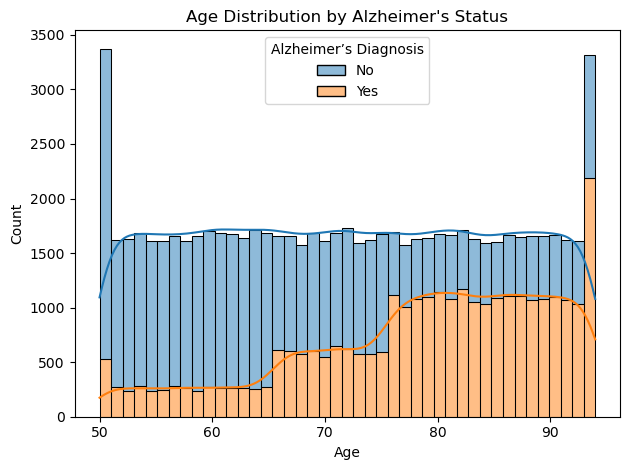

In [9]:
# Create age distribution by target variable
sns.histplot(data=df, x='Age', hue=target_column, kde=True, multiple='stack')
plt.title('Age Distribution by Alzheimer\'s Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('age_by_alzheimers.png')
plt.show()

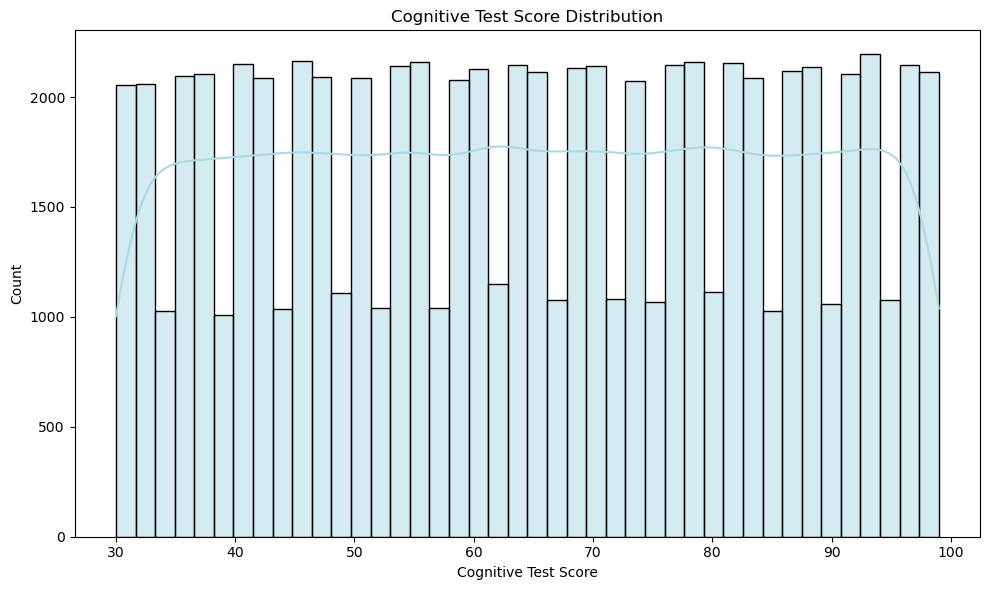

In [11]:
# 2. Cognitive Test Score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Cognitive Test Score', kde=True, color='lightblue')
plt.title('Cognitive Test Score Distribution')
plt.xlabel('Cognitive Test Score')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('cognitive_score_distribution.png')
plt.show()

In [ ]:
# Create a clean, simple correlation heatmap
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()

# Create the heatmap with clean design
sns.heatmap(correlation,
            annot=True,           # Show values
            cmap='coolwarm',      # Color scheme
            fmt='.2f',            # Two decimal places
            linewidths=0.5)       # Add subtle lines between cells

# Add clear title
plt.title('Correlation Between Numerical Features', fontsize=14)

# Fix layout and save
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show(

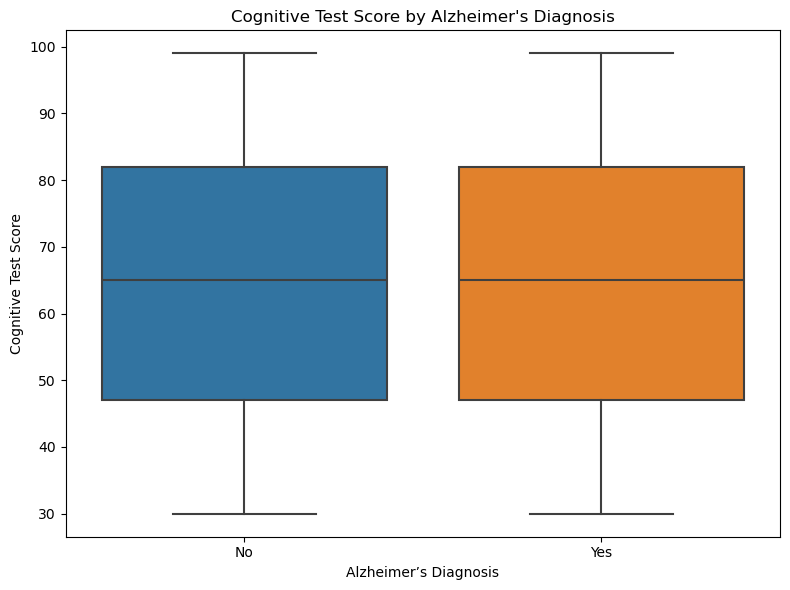

In [13]:
# 4. Box plot of Cognitive Score by Diagnosis
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x=target_column, y='Cognitive Test Score')
plt.title('Cognitive Test Score by Alzheimer\'s Diagnosis')
plt.tight_layout()
plt.savefig('cognitive_boxplot.png')
plt.show()

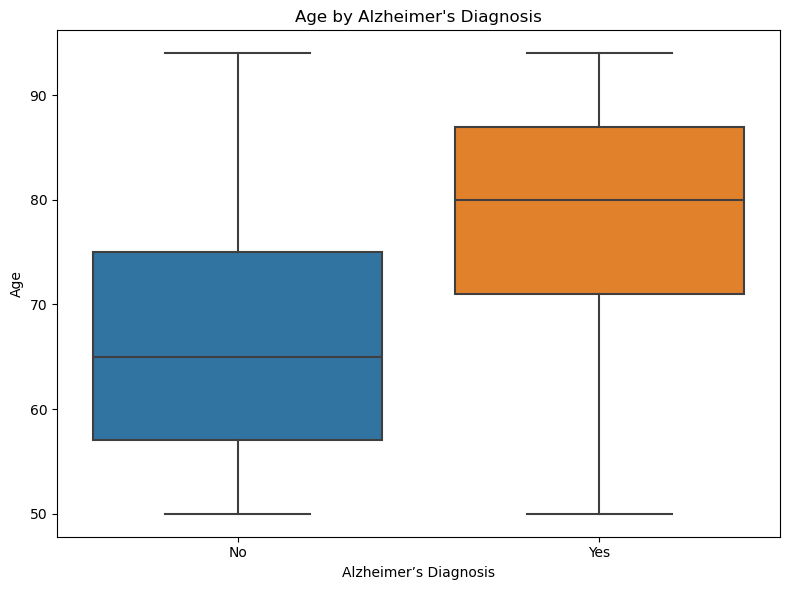

In [14]:
# 5. Boxplot of Age by Diagnosis
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x=target_column, y='Age')
plt.title('Age by Alzheimer\'s Diagnosis')
plt.tight_layout()
plt.savefig('age_boxplot.png')
plt.show()


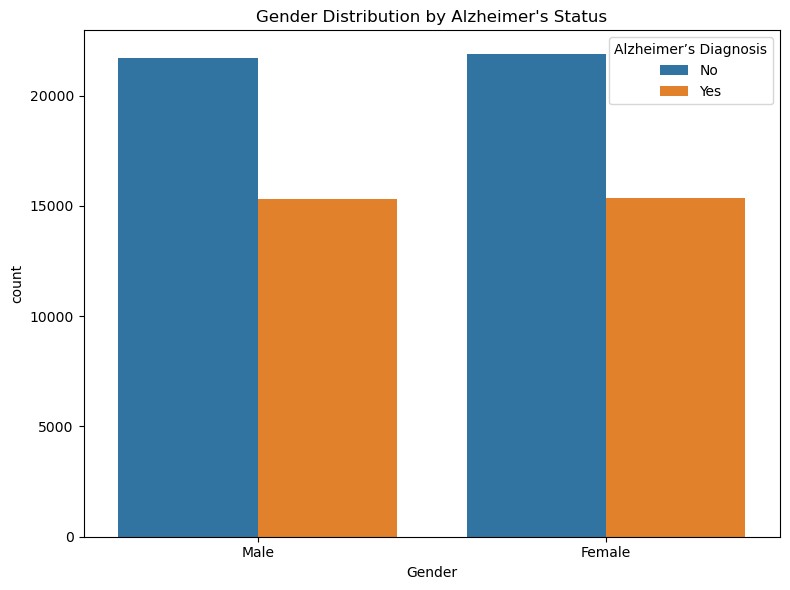

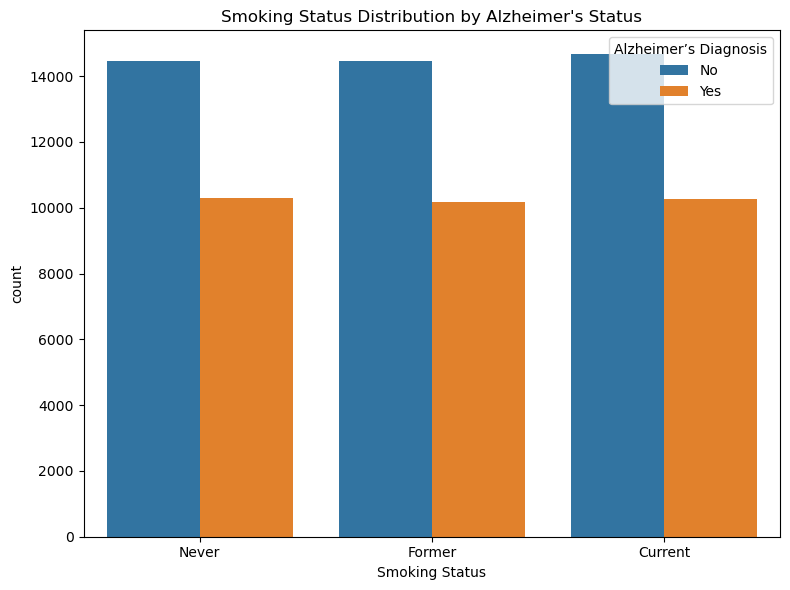

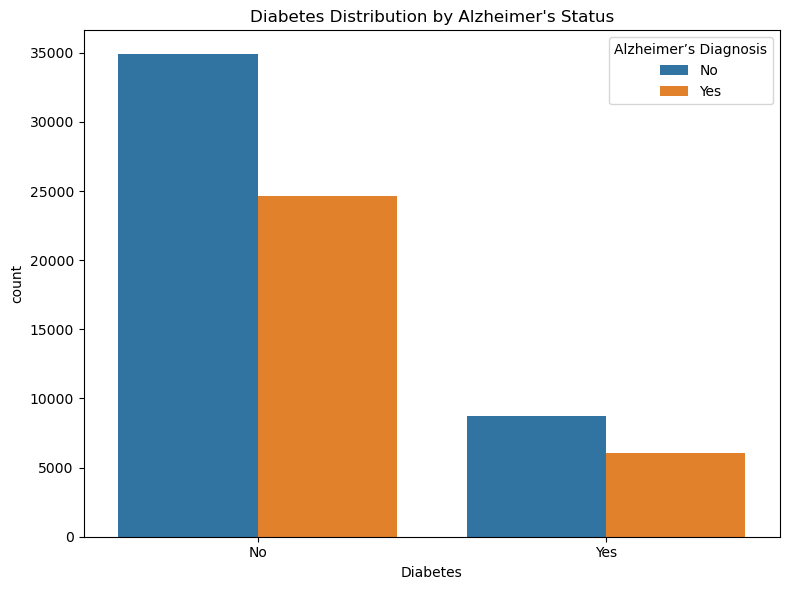

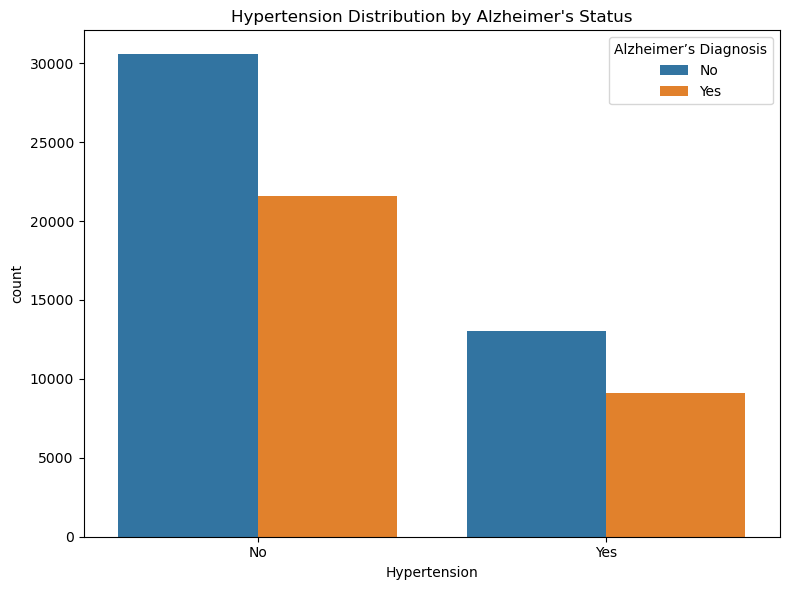

In [15]:
# Count plots for key categorical variables
categorical_vars = ['Gender', 'Smoking Status', 'Diabetes', 'Hypertension']
for var in categorical_vars:
    if var in df.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=var, hue=target_column)
        plt.title(f'{var} Distribution by Alzheimer\'s Status')
        plt.tight_layout()
        plt.savefig(f'{var.lower().replace(" ", "_")}_distribution.png')
        plt.show()

In [16]:
# Feature Engineering and Balancing

print("\n" + "="*50)
print("FEATURE ENGINEERING AND BALANCING")
print("="*50)

# Step 5.1: Separate features and target
target_column = df.columns[-1]  # Assuming target is the last column
X = df.drop(columns=[target_column])
y = df[target_column]

print(f"Target column: {target_column}")
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


FEATURE ENGINEERING AND BALANCING
Target column: Alzheimer’s Diagnosis
Features shape: (74283, 24)
Target distribution:
Alzheimer’s Diagnosis
No     43570
Yes    30713
Name: count, dtype: int64


In [17]:
#  Preprocess data
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Create and apply preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)
print(f"\nPreprocessed feature matrix shape: {X_preprocessed.shape}")


Numerical features: 4
Categorical features: 20

Preprocessed feature matrix shape: (74283, 54)


In [18]:
#  Create interaction terms
print("\nCreating interaction terms...")
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_preprocessed)
print(f"Feature matrix with interactions shape: {X_interactions.shape}")


Creating interaction terms...
Feature matrix with interactions shape: (74283, 1485)


In [ ]:
#  Perform feature selection with RFE
print("\nPerforming feature selection with Recursive Feature Elimination...")
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create base model for feature selection
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create RFECV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=cv,
    scoring='roc_auc',
    min_features_to_select=5
)

# Fit RFECV
X_selected = rfecv.fit_transform(X_interactions, y)
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected feature matrix shape: {X_selected.shape}")

# Plot feature selection results
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (ROC AUC)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title('Feature Selection using RFE with Cross-Validation')
plt.tight_layout()
plt.savefig('rfe_feature_selection.png')
plt.show()


Performing feature selection with Recursive Feature Elimination...


In [ ]:
#  Apply SMOTE to balance the classes
print("\nApplying SMOTE to balance the classes...")
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, y)

print(f"Original data shape: {X_selected.shape}")
print(f"Balanced data shape: {X_balanced.shape}")
print(f"Original target distribution:\n{pd.Series(y).value_counts()}")
print(f"Balanced target distribution:\n{pd.Series(y_balanced).value_counts()}")

# Visualize class balance before and after SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Alzheimer\'s Diagnosis')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_balanced)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Alzheimer\'s Diagnosis')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('class_balance_comparison.png')
plt.show()

print("\nFeature engineering, selection, and balancing complete!")